### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Heart Failure Prediction Dataset
(Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data)

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("HeartFailureData_75M25F_PCA_KNN_predictions.csv")

print(knn_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.810107       1
1    1       1  0.720647       1
2    1       1  0.906213       1
3    1       1  0.728721       1
4    0       0  0.478459       0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["Sex"].values

# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_knn = gender_knn

print("Example rows:\n", knn_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.810107       1
1    1       1  0.720647       1
2    1       1  0.906213       1
3    1       1  0.728721       1
4    0       0  0.478459       0


In [5]:
# protected_attr = Sex column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EOD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EOD - KNN
Demographic Parity Difference: 0.3796
Equalized Odds Difference: 0.0521


## Fairness Metrics – KNN

- **Demographic Parity Difference (DPD): 0.3796**  
  This indicates a **large disparity in selection rates** between male and female groups. The model is far from gender-neutral in how often it assigns positive outcomes, strongly favoring one group.

- **Equalized Odds Difference (EOD): 0.0521**  
  Despite the selection rate gap, the **error rates (TPR and FPR)** across genders are relatively close, with only a **moderate difference**. This suggests the model is more balanced in predictive performance once conditioned on the true label.

### Interpretation
The KNN model shows **substantial demographic bias** (unfairness in positive predictions being distributed unevenly across genders), but **moderate fairness in error rates** (similar TPR/FPR across groups). In practice, this means men and women receive predictions with comparable accuracy, but one gender is **more frequently given positive outcomes**.

---

In [6]:
# MetricFrame for extended analysis
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.868421   0.555556  0.833333  0.666667        0.236842   
1                    0.890411   0.944444  0.885417  0.913978        0.616438   

                          tpr    fpr    tnr       fnr  
sensitive_feature_0                                    
0                    0.833333  0.125  0.875  0.166667  
1                    0.885417  0.100  0.900  0.114583  


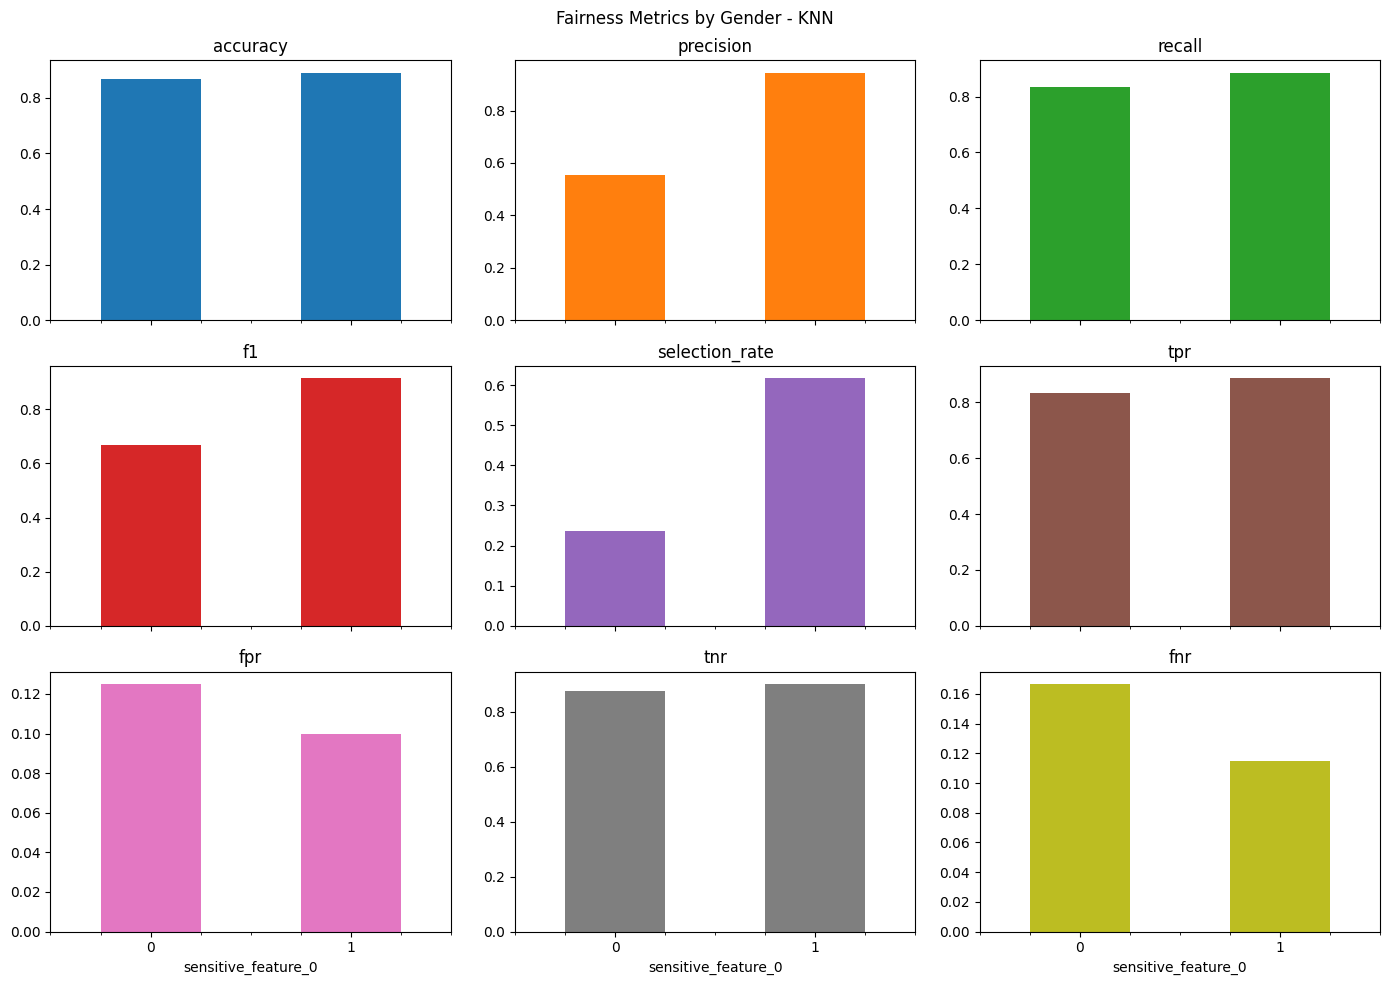


Between-group differences (max group − min group):
accuracy          0.021990
precision         0.388889
recall            0.052083
f1                0.247312
selection_rate    0.379596
tpr               0.052083
fpr               0.025000
tnr               0.025000
fnr               0.052083
dtype: float64

Between-group ratios (min / max):
accuracy          0.975304
precision         0.588235
recall            0.941176
f1                0.729412
selection_rate    0.384211
tpr               0.941176
fpr               0.800000
tnr               0.972222
fnr               0.687500
dtype: float64

Disparate Impact Ratio (selection rate): 0.3842
Equality of Opportunity Difference (TPR gap): 0.0521


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

## Fairness Metrics by Gender – KNN Model

This section analyzes the fairness of the **KNN classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8684     | 0.8904   |
| Precision        | 0.5556     | 0.9444   |
| Recall (Sensitivity) | 0.8333 | 0.8854   |
| F1 Score         | 0.6667     | 0.9140   |
| Selection Rate   | 0.2368     | 0.6164   |
| True Positive Rate (TPR) | 0.8333 | 0.8854 |
| False Positive Rate (FPR) | 0.1250 | 0.1000 |
| True Negative Rate (TNR) | 0.8750 | 0.9000 |
| False Negative Rate (FNR) | 0.1667 | 0.1146 |

---

### Between-Group Disparities

- **Precision Gap (0.39)** → Predictions for males are much more reliable than for females.  
- **F1 Gap (0.25)** → Overall predictive quality is higher for males.  
- **Selection Rate Gap (0.38)** → Males are more than **2.5 times** as likely to receive a positive prediction compared to females.  

Smaller differences:  
- **Recall / TPR Gap (0.05)** → Both genders are detected at similar rates.  
- **FPR/TNR Gaps (0.025 each)** → Error rates on negatives are nearly balanced.

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.975 |
| Precision                 | 0.588 |
| Recall                    | 0.941 |
| F1 Score                  | 0.729 |
| Selection Rate            | 0.384 |
| TPR                       | 0.941 |
| FPR                       | 0.800 |
| TNR                       | 0.972 |
| FNR                       | 0.688 |

- **Selection Rate Ratio = 0.384 (< 0.8)** → Violates the **80% rule**, showing **strong disparate impact** against females.  
- **Precision Ratio = 0.59** → Female predictions are far less precise.  
- **Recall/TPR Ratios (~0.94)** → Closer to parity, suggesting sensitivity is fairly balanced.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.3842**  
  → Females have far lower chance of receiving a positive prediction.  

- **Equality of Opportunity Difference (TPR gap): 0.0521**  
  → Relatively small gap, meaning both genders are identified at similar rates when truly positive.  

---

### Interpretation

- The **KNN model favors males**, especially in **precision, F1 score, and selection rate**. This means that males are **not only more likely to receive positive outcomes, but those outcomes are more accurate** compared to females.  
- While **error rates (TPR, FPR, TNR, FNR)** are relatively balanced across genders, the **disproportionately low selection rate for females** highlights a **systemic bias in access to positive predictions**.  
- From a fairness perspective, this imbalance is critical: even though the model treats both genders similarly in terms of sensitivity, **females are disadvantaged in terms of opportunity and predictive reliability**.

---

In [8]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.958333
1                    0.908646

KNN - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.083038
1                    0.104072


## Group-Specific ROC-AUC and Brier Score – KNN Model  

This section evaluates **calibration and ranking performance** of the KNN model across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9583     | 0.9086   |
| Brier Score   | 0.0830     | 0.1041   |

---

### Interpretation

- **ROC-AUC (Discrimination Ability):**  
  - The model shows **very strong ranking performance** for both genders, with AUC values above 0.90.  
  - However, females (0.958) have slightly higher discrimination ability compared to males (0.909), suggesting the model ranks positive vs. negative cases more effectively for females.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Females (0.083) achieve a lower Brier score than males (0.104), indicating **better calibrated probability estimates** for the female group.  
  - For males, the higher score reflects **slightly less reliable probability predictions**, even though overall performance remains acceptable.  

---

### Conclusion  

The KNN model provides **better discrimination and calibration for females compared to males**, in contrast to earlier findings where males benefited more in terms of **precision, F1 score, and selection rate**.  
This highlights a nuanced fairness perspective: **females receive more accurate probability estimates, while males are favored in classification outcomes.**

---

### Bias detection for the Decision Tree Model

In [9]:
# Load DT results
dt_df = pd.read_csv("HeartFailureData_75M25F_TunedDT_predictions.csv")
print(dt_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.000000       0
1    1       1  1.000000       1
2    1       1  1.000000       1
3    1       1  0.666667       1
4    0       0  1.000000       1


In [10]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred"].values
gender_dt = dt_df["Sex"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt

print("Example rows:\n", dt_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.000000       0
1    1       1  1.000000       1
2    1       1  1.000000       1
3    1       1  0.666667       1
4    0       0  1.000000       1


In [11]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.2549
Equalized Odds Difference: 0.0812


## Fairness Metrics – Decision Tree (DT)

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the tuned Decision Tree model.  

### Results
- **Demographic Parity Difference (DPD): 0.2549**  
- **Equalized Odds Difference (EOD): 0.0812**

---

### Interpretation

- **DPD (0.255):**  
  A moderate demographic parity difference indicates that **males (privileged group) still receive positive predictions more frequently than females (unprivileged group)**. While the disparity is not extreme, it reflects an unequal distribution of outcomes across genders.  

- **EOD (0.081):**  
  The equalized odds difference is small, suggesting that **error rates (true positive and false positive rates) are relatively well balanced between groups**. Once classified, the model performs similarly across genders in terms of predictive accuracy.  

---

### Conclusion

The tuned Decision Tree shows **some bias in outcome distribution (DPD)**, slightly favoring males in positive predictions, while maintaining **comparatively fair error rates (EOD)**. This points to a fairness concern primarily in **access to positive outcomes**, rather than in the consistency of predictive errors.

---


DT - Fairness Metrics by Gender:
                     accuracy  precision    recall       f1  selection_rate  \
sensitive_feature_0                                                           
0                    0.736842   0.357143  0.833333  0.50000        0.368421   
1                    0.828767   0.890110  0.843750  0.86631        0.623288   

                          tpr      fpr      tnr       fnr  
sensitive_feature_0                                        
0                    0.833333  0.28125  0.71875  0.166667  
1                    0.843750  0.20000  0.80000  0.156250  


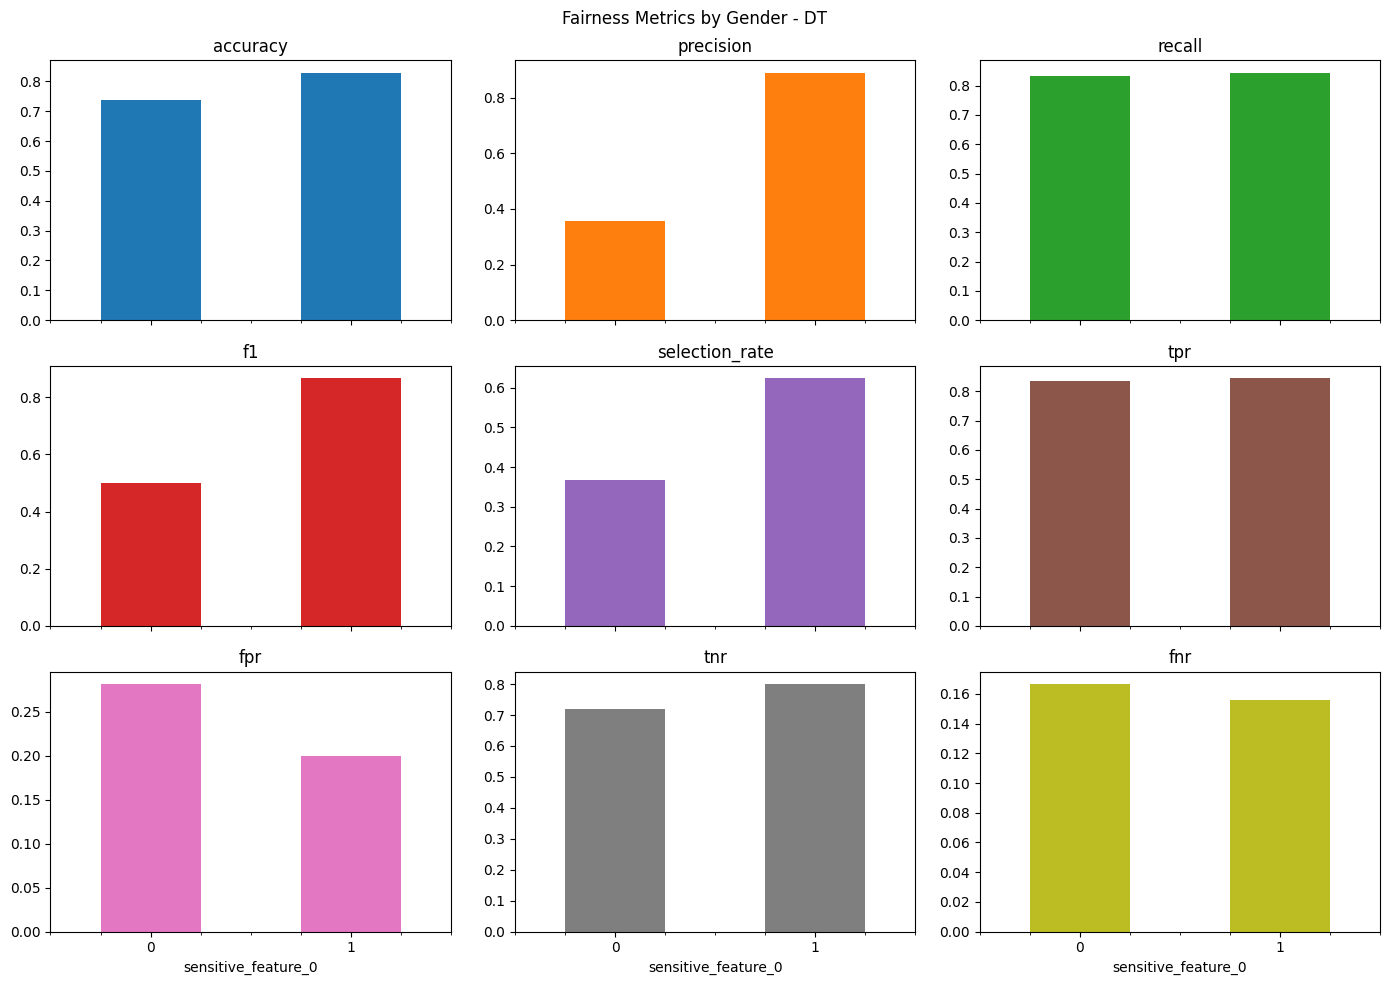


Between-group differences (max group − min group):
accuracy          0.091925
precision         0.532967
recall            0.010417
f1                0.366310
selection_rate    0.254867
tpr               0.010417
fpr               0.081250
tnr               0.081250
fnr               0.010417
dtype: float64

Between-group ratios (min / max):
accuracy          0.889082
precision         0.401235
recall            0.987654
f1                0.577160
selection_rate    0.591093
tpr               0.987654
fpr               0.711111
tnr               0.898438
fnr               0.937500
dtype: float64

Disparate Impact Ratio (selection rate): 0.5911
Equality of Opportunity Difference (TPR gap): 0.0104


In [12]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT - Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

## Fairness Metrics by Gender – Decision Tree (DT)

This section analyzes the fairness of the **Decision Tree classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.7368     | 0.8288   |
| Precision        | 0.3571     | 0.8901   |
| Recall (Sensitivity) | 0.8333 | 0.8438   |
| F1 Score         | 0.5000     | 0.8663   |
| Selection Rate   | 0.3684     | 0.6233   |
| True Positive Rate (TPR) | 0.8333 | 0.8438 |
| False Positive Rate (FPR) | 0.2813 | 0.2000 |
| True Negative Rate (TNR) | 0.7188 | 0.8000 |
| False Negative Rate (FNR) | 0.1667 | 0.1563 |

---

### Between-Group Disparities

- **Precision Gap (0.53):** Males benefit from far higher precision than females.  
- **F1 Gap (0.37):** Prediction quality is substantially stronger for males.  
- **Selection Rate Gap (0.25):** Males are more likely to receive a positive prediction.  
- **FPR/TNR Gaps (0.08):** Females face more false positive errors, lowering specificity for that group.  
- **Recall/TPR Gap (0.01):** Sensitivity is nearly equal across genders, showing balanced detection of positives.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.889 |
| Precision                 | 0.401 |
| Recall                    | 0.988 |
| F1 Score                  | 0.577 |
| Selection Rate            | 0.591 |
| TPR                       | 0.988 |
| FPR                       | 0.711 |
| TNR                       | 0.898 |
| FNR                       | 0.938 |

- **Selection Rate Ratio = 0.591 (< 0.8 rule)** → Indicates **disparate impact** against females.  
- **Precision Ratio = 0.40** → Female predictions are far less reliable.  
- **Recall/TPR Ratios (~0.99)** → True positive detection is balanced across genders.  
- **FPR Ratio (0.71)** → Females experience more false alarms than males.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.5911**  
  → Females have substantially lower access to positive predictions compared to males.  

- **Equality of Opportunity Difference (TPR gap): 0.0104**  
  → Very small, indicating nearly equal sensitivity across genders.  

---

### Interpretation

- The **Decision Tree favors males** in terms of **precision, F1 score, and selection rate**, giving them more reliable and frequent positive outcomes.  
- **Females**, however, face weaker precision and more false positives, making predictions less trustworthy for this group.  
- Despite this, the model shows **fair recall/TPR across genders**, meaning that true positives are detected at similar rates.  
- Overall, the **primary fairness concern** lies in the **unequal distribution and reliability of positive outcomes (disparate impact against females)**, even though detection ability is balanced.

---

In [13]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.763021
1                    0.844479

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.238304
1                    0.155330


## Group-Specific ROC-AUC and Brier Score – Decision Tree (DT)

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the Decision Tree across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Results

| Metric      | Female (0) | Male (1) |
|-------------|------------|----------|
| ROC-AUC     | 0.7630     | 0.8445   |
| Brier Score | 0.2383     | 0.1553   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - Males (0.844) achieve higher ROC-AUC than females (0.763), meaning the model **discriminates positive vs. negative cases more effectively for males**.  
  - The gap indicates that the model ranks risks less accurately for females.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Males (0.155) have **better-calibrated probability estimates** compared to females (0.238).  
  - Female predictions are thus less reliable in terms of probability calibration.  

---

### Conclusion

The Decision Tree shows **superior discrimination and calibration for males**, while females experience weaker probability estimates and ranking quality. This reinforces earlier findings: although recall (sensitivity) was balanced, **males benefit from both better probability calibration and stronger ranking performance**, compounding the fairness concern for females.

---

### Bias detection for the Random Forest Model

In [14]:
rf_df = pd.read_csv("HeartFailureData_75M25F_BaselineRF_predictions.csv")
print(rf_df.head())

   Sex  y_true  y_prob  y_pred
0    1       1    0.91       1
1    1       1    0.41       0
2    1       1    0.97       1
3    1       1    0.55       1
4    0       0    0.56       1


In [15]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["Sex"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf

print("Example rows:\n", rf_df.head())

Example rows:
    Sex  y_true  y_prob  y_pred
0    1       1    0.91       1
1    1       1    0.41       0
2    1       1    0.97       1
3    1       1    0.55       1
4    0       0    0.56       1


In [16]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.4081
Equalized Odds Difference: 0.0833


## Fairness Metrics – Random Forest (RF)

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the Random Forest model.  

### Results
- **Demographic Parity Difference (DPD): 0.4081**  
- **Equalized Odds Difference (EOD): 0.0833**

---

### Interpretation

- **DPD (0.408):**  
  A large demographic parity difference indicates that **males (privileged group) receive positive predictions much more frequently than females (unprivileged group)**. This points to **substantial imbalance in outcome distribution**, reflecting disparate impact against females.  

- **EOD (0.083):**  
  The relatively small equalized odds difference suggests that **error rates (true positive and false positive rates) are fairly similar across genders**. Thus, once the model makes a classification, its treatment of male and female instances is more balanced.  

---

### Conclusion

The Random Forest exhibits **considerable bias in access to positive outcomes (DPD)**, strongly favoring males, while maintaining **more equitable error rates across genders (EOD)**. This means the primary fairness concern lies in the **distribution of predictions rather than predictive accuracy parity**.

---


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.894737   0.600000  1.000000  0.750000        0.263158   
1                    0.876712   0.897959  0.916667  0.907216        0.671233   

                          tpr    fpr    tnr       fnr  
sensitive_feature_0                                    
0                    1.000000  0.125  0.875  0.000000  
1                    0.916667  0.200  0.800  0.083333  


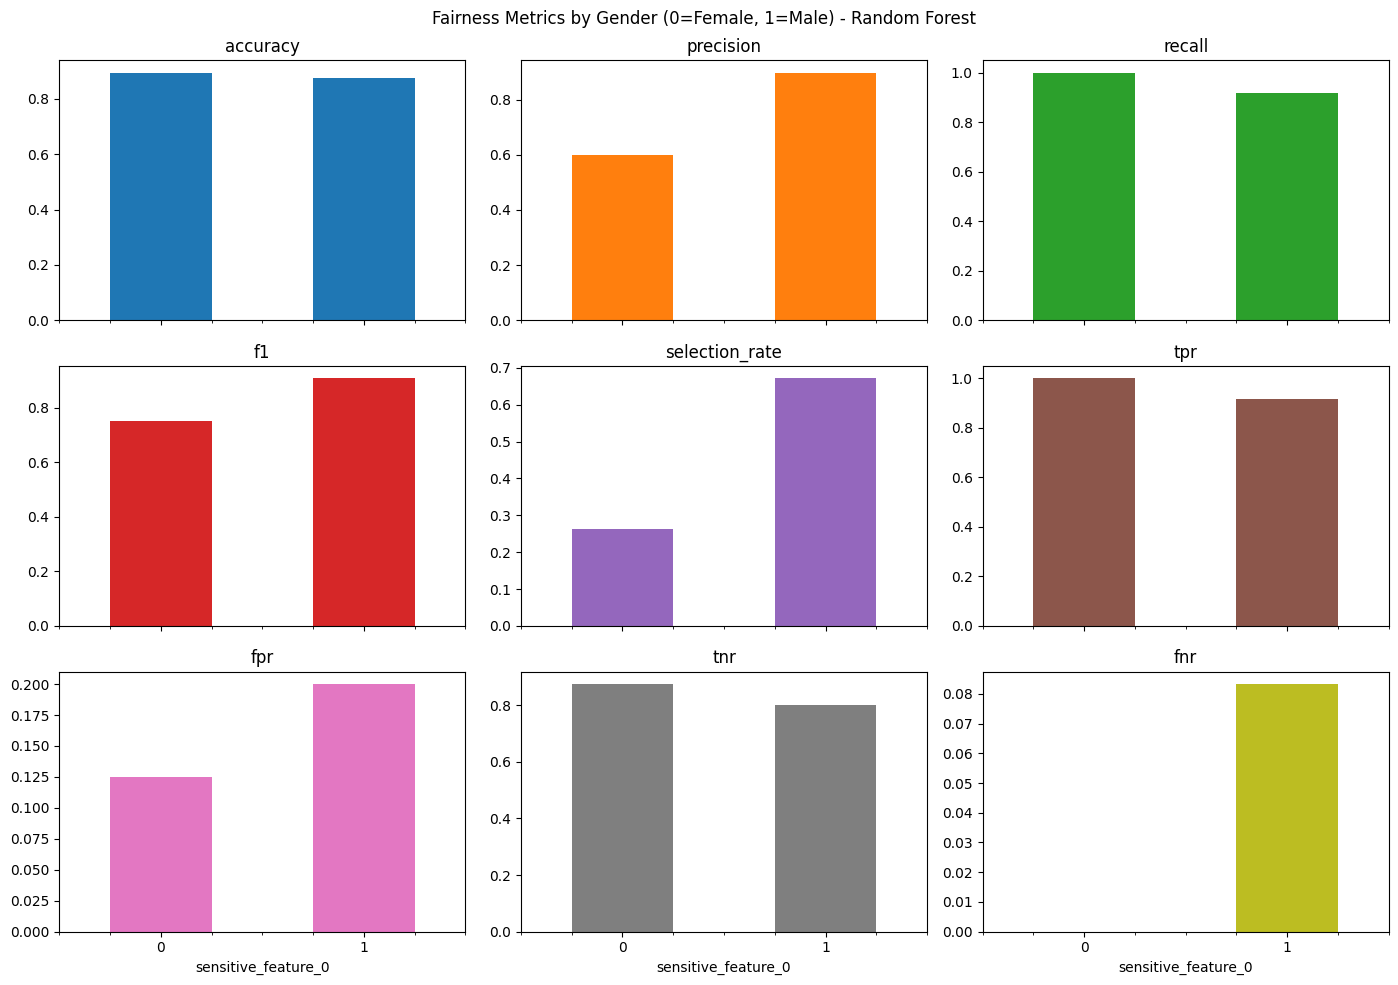


Between-group differences (max group − min group):
accuracy          0.018025
precision         0.297959
recall            0.083333
f1                0.157216
selection_rate    0.408075
tpr               0.083333
fpr               0.075000
tnr               0.075000
fnr               0.083333
dtype: float64

Between-group ratios (min / max):
accuracy          0.979855
precision         0.668182
recall            0.916667
f1                0.826705
selection_rate    0.392052
tpr               0.916667
fpr               0.625000
tnr               0.914286
fnr               0.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.3921
Equality of Opportunity Difference (TPR gap): 0.0833


In [17]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

## Fairness Metrics by Gender – Random Forest (RF)

This section analyzes the fairness of the **Random Forest classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8947     | 0.8767   |
| Precision        | 0.6000     | 0.8980   |
| Recall (Sensitivity) | 1.0000 | 0.9167   |
| F1 Score         | 0.7500     | 0.9072   |
| Selection Rate   | 0.2632     | 0.6712   |
| True Positive Rate (TPR) | 1.0000 | 0.9167 |
| False Positive Rate (FPR) | 0.1250 | 0.2000 |
| True Negative Rate (TNR) | 0.8750 | 0.8000 |
| False Negative Rate (FNR) | 0.0000 | 0.0833 |

---

### Between-Group Disparities

- **Precision Gap (0.30):** Males achieve much higher precision, indicating their positive predictions are more reliable.  
- **F1 Gap (0.16):** Predictive quality is stronger for males overall.  
- **Selection Rate Gap (0.41):** Males are more than **2.5 times as likely** to receive a positive prediction as females.  
- **Recall/TPR Gap (0.08):** Females achieve perfect recall (100%), while recall for males is slightly lower (91.7%).  
- **FPR/TNR Gaps (0.075):** Males experience higher false positive rates and lower specificity.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.980 |
| Precision                 | 0.668 |
| Recall                    | 0.917 |
| F1 Score                  | 0.827 |
| Selection Rate            | 0.392 |
| TPR                       | 0.917 |
| FPR                       | 0.625 |
| TNR                       | 0.914 |
| FNR                       | 0.000 |

- **Selection Rate Ratio = 0.392 (< 0.8 rule)** → Indicates **disparate impact** against females.  
- **Precision Ratio = 0.67** → Positive predictions for females are less reliable.  
- **Recall/TPR Ratios (~0.92)** → Sensitivity is relatively balanced, but females actually have a higher recall.  
- **FPR Ratio (0.63)** → Males are more prone to false positives compared to females.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.3921**  
  → Females are far less likely to receive positive predictions.  

- **Equality of Opportunity Difference (TPR gap): 0.0833**  
  → Small but notable, as females achieve perfect sensitivity while males have slightly reduced detection.  

---

### Interpretation

- The **Random Forest strongly favors males** in terms of **precision, F1 score, and selection rate**, meaning they are more frequently and more reliably predicted as positive.  
- **Females, however, benefit from higher recall and lower false negative rates**, suggesting that when positive cases occur, the model is more successful in identifying them for females.  
- Males face a trade-off: while they receive many more positive predictions, they also suffer from **higher false positive rates**.  
- The central fairness concern lies in the **unequal distribution of positive outcomes**, as females have much lower selection rates despite stronger recall.  

---

In [18]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_rf
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.981771
1                    0.894062

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.098376
1                    0.103088


## Group-Specific ROC-AUC and Brier Score – Random Forest (RF)

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the Random Forest across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9818     | 0.8941   |
| Brier Score   | 0.0984     | 0.1031   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - Females (0.982) achieve near-perfect discrimination ability, showing the model is extremely effective at ranking positive vs. negative cases.  
  - Males also perform strongly (0.894), but at a notably lower level than females.  
  - This indicates the **Random Forest distinguishes outcomes more effectively for females**.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Females (0.098) achieve a slightly lower Brier score than males (0.103), meaning their predicted probabilities are **better calibrated**.  
  - Both scores are reasonably low, showing generally good probability estimation, but calibration is more reliable for females.  

---

### Conclusion

The Random Forest demonstrates **superior discrimination (ROC-AUC) and calibration (Brier score) for females compared to males**.  
This complements earlier findings: while **males are favored in classification outcomes (precision, F1 score, and selection rate)**, **females benefit from more accurate probability estimates and stronger ranking performance**.  
This again underscores a fairness trade-off: **males receive more positive outcomes, but females receive higher quality predictions**.  

---

### Bias detection for MLP

In [19]:
mlp_df = pd.read_csv("HeartFailureData_75M25F_AdamMLP_predictions.csv")
print(mlp_df.head())

   Sex  y_true    y_prob  y_pred
0    1       1  0.951479       1
1    1       1  0.029132       0
2    1       1  0.810705       1
3    1       1  0.225562       0
4    0       0  0.612828       1


In [20]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["Sex"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    Sex  y_true    y_prob  y_pred
0    1       1  0.951479       1
1    1       1  0.029132       0
2    1       1  0.810705       1
3    1       1  0.225562       0
4    0       0  0.612828       1


In [21]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EOD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EOD - MLP
Demographic Parity Difference (MLP): 0.3396
Equalized Odds Difference (MLP): 0.1562


## Fairness Metrics – Multilayer Perceptron (MLP)

This section reports **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** for the MLP model.  

### Results
- **Demographic Parity Difference (DPD): 0.3396**  
- **Equalized Odds Difference (EOD): 0.1562**

---

### Interpretation

- **DPD (0.340):**  
  The demographic parity difference shows that **males (privileged group) receive positive predictions substantially more often than females (unprivileged group)**. This highlights **outcome imbalance** and suggests disparate impact against females.  

- **EOD (0.156):**  
  The equalized odds difference is moderately high, indicating that **true positive and false positive rates differ more strongly across genders** compared to other models. This means the **error distribution is less balanced**, and the MLP treats male and female groups differently in classification performance.  

---

### Conclusion

The MLP exhibits **both outcome imbalance (DPD)** and **notable error-rate disparity (EOD)**.  
Compared to other models, this suggests that the MLP not only favors males in terms of **access to positive predictions**, but also **introduces unequal misclassification behavior across genders**, raising stronger fairness concerns than models like KNN, DT, or RF.

---


MLP Fairness Metrics by Gender:
                     accuracy  precision   recall        f1  selection_rate  \
sensitive_feature_0                                                           
0                    0.894737   0.600000  1.00000  0.750000        0.263158   
1                    0.849315   0.920455  0.84375  0.880435        0.602740   

                         tpr    fpr    tnr      fnr  
sensitive_feature_0                                  
0                    1.00000  0.125  0.875  0.00000  
1                    0.84375  0.140  0.860  0.15625  


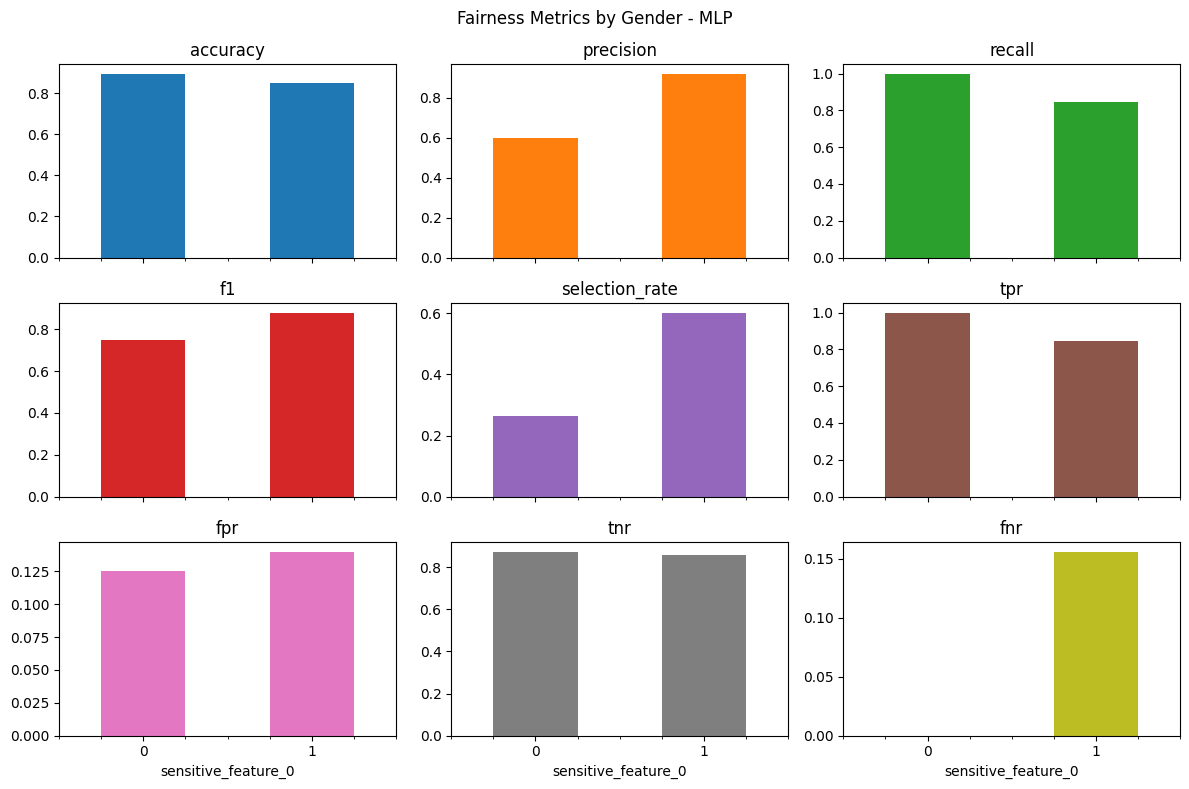


Between-group differences (max group − min group):
accuracy          0.045422
precision         0.320455
recall            0.156250
f1                0.130435
selection_rate    0.339582
tpr               0.156250
fpr               0.015000
tnr               0.015000
fnr               0.156250
dtype: float64

Between-group ratios (min / max):
accuracy          0.949234
precision         0.651852
recall            0.843750
f1                0.851852
selection_rate    0.436603
tpr               0.843750
fpr               0.892857
tnr               0.982857
fnr               0.000000
dtype: float64

Disparate Impact Ratio (selection rate): 0.4366
Equality of Opportunity Difference (TPR gap): 0.1562


In [22]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

## Fairness Metrics by Gender – Multilayer Perceptron (MLP)

This section analyzes the fairness of the **MLP classifier** across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Group-Specific Results

| Metric           | Female (0) | Male (1) |
|------------------|------------|----------|
| Accuracy         | 0.8947     | 0.8493   |
| Precision        | 0.6000     | 0.9205   |
| Recall (Sensitivity) | 1.0000 | 0.8438   |
| F1 Score         | 0.7500     | 0.8804   |
| Selection Rate   | 0.2632     | 0.6027   |
| True Positive Rate (TPR) | 1.0000 | 0.8438 |
| False Positive Rate (FPR) | 0.1250 | 0.1400 |
| True Negative Rate (TNR) | 0.8750 | 0.8600 |
| False Negative Rate (FNR) | 0.0000 | 0.1563 |

---

### Between-Group Disparities

- **Precision Gap (0.32):** Males have much higher precision, making their positive predictions more reliable.  
- **Recall/TPR Gap (0.16):** Females achieve perfect recall (100%) while males lag behind (84.4%), meaning the model **never misses positive cases for females** but does so for males.  
- **F1 Gap (0.13):** Predictive quality is overall stronger for males, but females benefit from perfect sensitivity.  
- **Selection Rate Gap (0.34):** Males are more than **2.3 times as likely** to receive a positive prediction.  
- **FPR/TNR Gaps (~0.015):** Very small, showing similar misclassification of negatives across genders.  

---

### Fairness Ratios (Female / Male)

| Metric                   | Ratio |
|---------------------------|-------|
| Accuracy                  | 0.949 |
| Precision                 | 0.652 |
| Recall                    | 0.844 |
| F1 Score                  | 0.852 |
| Selection Rate            | 0.437 |
| TPR                       | 0.844 |
| FPR                       | 0.893 |
| TNR                       | 0.983 |
| FNR                       | 0.000 |

- **Selection Rate Ratio = 0.437 (< 0.8 rule)** → Indicates **disparate impact** against females.  
- **Precision Ratio = 0.65** → Female predictions are less precise.  
- **Recall/TPR Ratios (~0.84)** → Females benefit from higher sensitivity, while males are disadvantaged.  
- **FPR/TNR Ratios (~0.89–0.98)** → Negative class errors are balanced across genders.  

---

### Key Fairness Indicators

- **Disparate Impact (Selection Rate): 0.4366**  
  → Females are much less likely to receive positive predictions compared to males.  

- **Equality of Opportunity Difference (TPR gap): 0.1562**  
  → Relatively large, as females have **perfect sensitivity**, while males miss some positive cases.  

---

### Interpretation

- The **MLP favors males** in terms of **precision, F1 score, and likelihood of receiving positive predictions**.  
- However, it **favors females in sensitivity (recall/TPR)**, meaning the model successfully captures all female positive cases, but not all male ones.  
- While error rates for negatives (FPR/TNR) are fairly balanced, the **main fairness concerns** are:  
  1. **Unequal access to positive outcomes (disparate impact against females)**.  
  2. **Unequal error distribution**, as the model misses more positive cases for males than for females.  

---

In [23]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.968750
1                    0.904167

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.079290
1                    0.117977


## Group-Specific ROC-AUC and Brier Score – Multilayer Perceptron (MLP)

This section evaluates **discrimination ability (ROC-AUC)** and **probability calibration (Brier score)** of the MLP across gender groups, where  
- **0 = Female (Unprivileged group)**  
- **1 = Male (Privileged group)**  

### Results

| Metric        | Female (0) | Male (1) |
|---------------|------------|----------|
| ROC-AUC       | 0.9688     | 0.9042   |
| Brier Score   | 0.0793     | 0.1180   |

---

### Interpretation

- **ROC-AUC (Ranking Performance):**  
  - The model achieves very strong ranking ability for both genders, with both scores above 0.90.  
  - Females (0.969) outperform males (0.904), indicating the model is **better at separating positive and negative cases for females**.  

- **Brier Score (Calibration Quality):**  
  - Lower is better. Females (0.079) have substantially better calibration than males (0.118).  
  - This suggests that the **probability estimates for females are more accurate and reliable**, while for males they are less well-calibrated.  

---

### Conclusion

The MLP provides **superior discrimination and probability calibration for females**, while **males are disadvantaged in terms of probability quality despite receiving more positive outcomes overall**.  
This reinforces earlier fairness findings: **males benefit in classification outcomes (precision, F1, and selection rate), but females benefit from stronger ranking performance and better-calibrated predictions**.  

---

## Comparison of Results

In [24]:
# Build results dict 
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("HeartFailureData_75M25F_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)


In [25]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [26]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.3796,0.0521
DT,0.2549,0.0812
RF,0.4081,0.0833
MLP,0.3396,0.1562


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.8684     0.5556  0.8333  0.6667          0.2368  0.8333   
      1         0.8904     0.9444  0.8854  0.9140          0.6164  0.8854   
DT    0         0.7368     0.3571  0.8333  0.5000          0.3684  0.8333   
      1         0.8288     0.8901  0.8438  0.8663          0.6233  0.8438   
RF    0         0.8947     0.6000  1.0000  0.7500          0.2632  1.0000   
      1         0.8767     0.8980  0.9167  0.9072          0.6712  0.9167   
MLP   0         0.8947     0.6000  1.0000  0.7500          0.2632  1.0000   
      1         0.8493     0.9205  0.8438  0.8804          0.6027  0.8438   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.1250  0.8750  0.1667  
      1       0.1000  0.9000  0.1146  
DT    0       0.2812  0.7188  0.1667  
      1       0.2000  0.8000  0.1562  
RF    0       0.1250  0.8750  0.0000  
      1       0.2000  0.8000  0.0833  
MLP   0       0.1250  0.8750  0.0000  
      1       0.1400  0.8600  0.1562

## Fairness and Performance Evaluation Across Models

This section interprets the fairness and evaluation metrics for the **KNN, Decision Tree (DT), Random Forest (RF), and MLP** models.  

---

### Demographic Parity Difference (DPD) & Equalized Odds Difference (EOD)

| Model | DPD     | EOD     |
|-------|---------|---------|
| KNN   | 0.3796  | 0.0521  |
| DT    | 0.2549  | 0.0812  |
| RF    | 0.4081  | 0.0833  |
| MLP   | 0.3396  | 0.1562  |

- **DPD** is highest for **RF (0.41)**, indicating the strongest disparity in positive outcome distribution between males and females.  
- **DT has the lowest DPD (0.25)**, suggesting the most balanced outcome distribution among the models.  
- **EOD** is lowest for **KNN (0.05)**, meaning it achieves the most balanced error rates between genders.  
- **MLP has the highest EOD (0.16)**, reflecting more pronounced error-rate disparities across genders.  

---

### Group-Specific Performance

#### KNN
- **Females (0):** Lower precision (0.56) and F1 (0.67), but recall (0.83) is solid.  
- **Males (1):** High precision (0.94) and F1 (0.91), much higher selection rate (0.62 vs. 0.24 for females).  
- **Interpretation:** The model **favors males** in access to positive predictions and prediction reliability.

#### Decision Tree (DT)
- **Females (0):** Very low precision (0.36) and F1 (0.50), though recall remains strong (0.83).  
- **Males (1):** Much higher precision (0.89) and F1 (0.87), with a higher selection rate (0.62 vs. 0.37).  
- **Interpretation:** DT **favors males in predictive outcomes**, but at the cost of **more false positives for females (FPR = 0.28)**. Despite its lower DPD compared to other models, disparities in prediction quality remain evident.

#### Random Forest (RF)
- **Females (0):** Perfect recall (1.0) and TPR (1.0) – the model never misses positive cases for females. Precision is low (0.60), and selection rate is modest (0.26).  
- **Males (1):** Much higher precision (0.90) and F1 (0.91), with selection rate more than double (0.67). Recall (0.92) is slightly lower than females.  
- **Interpretation:** RF favors males in **outcome access and reliability**, but females uniquely benefit from **perfect sensitivity** (no false negatives).

#### MLP
- **Females (0):** Perfect recall (1.0), no false negatives, but weaker precision (0.60) and F1 (0.75).  
- **Males (1):** Higher precision (0.92) and F1 (0.88), but recall is weaker (0.84). Selection rate again favors males (0.60 vs. 0.26).  
- **Interpretation:** MLP reflects a **clear trade-off**: females get perfect sensitivity, but males dominate in precision and outcome access.

---

### Observations

1. **Outcome Imbalance (DPD):**  
   All models favor males in terms of **selection rate** (access to positive predictions). DT shows the **lowest disparity (DPD = 0.25)**, while RF shows the highest (0.41).  

2. **Error Rate Balance (EOD):**  
   - **KNN** is the most balanced (lowest EOD = 0.05).  
   - **MLP** shows the largest error-rate disparity (EOD = 0.16).  

3. **Trade-Offs Between Groups:**  
   - **Males consistently benefit from higher precision, F1, and selection rates across all models.**  
   - **Females benefit from higher recall/TPR in RF and MLP (perfect sensitivity), but at the cost of fewer positive opportunities.**  

4. **Model-Specific Notes:**  
   - **KNN:** Balanced error rates, but strong outcome disparity.  
   - **DT:** Lowest DPD overall, but females face much weaker precision and higher false positives.  
   - **RF:** Favors males overall, but uniquely gives females perfect recall.  
   - **MLP:** Largest disparity in error rates, with females gaining in sensitivity but not in outcome access.  

---

### Summary

- Across all models, **males are systematically advantaged in access to positive predictions (selection rate and precision)**.  
- **DT achieves the lowest disparity in outcome distribution (DPD),** making it the relatively fairest in this dimension, though disparities in prediction quality persist.  
- **KNN is strongest in error-rate balance (lowest EOD).**  
- **RF and MLP highlight a trade-off:** females achieve perfect recall (no missed positives), but males dominate in precision and outcome access.  
- The overarching fairness concern remains **disparate impact (DPD)**, reflecting unequal access to positive outcomes — amplified by the **imbalanced training set (75% male vs. 25% female)**.

---

In [27]:
# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()

# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Female (0),Male (1)
Model,,
KNN,0.9583,0.9086
DT,0.7630,0.8445
RF,0.9818,0.8941
MLP,0.9688,0.9042


,Female (0),Male (1)
Model,,
KNN,0.0830,0.1041
DT,0.2383,0.1553
RF,0.0984,0.1031
MLP,0.0793,0.1180


## Discrimination (ROC-AUC) and Calibration (Brier Score) by Gender  

This section evaluates **discrimination ability (ROC-AUC – higher is better)** and **probability calibration (Brier score – lower is better)** across gender groups for all four models utilized.  

---

### 1. ROC-AUC by Gender  

| Model | Female (0) | Male (1) |
|-------|------------|----------|
| KNN   | 0.9583     | 0.9086   |
| DT    | 0.7630     | 0.8445   |
| RF    | 0.9818     | 0.8941   |
| MLP   | 0.9688     | 0.9042   |

- **KNN, RF, and MLP:** Females achieve higher ROC-AUC than males, showing that these models **discriminate positive vs. negative cases more effectively for females**.  
- **Decision Tree (DT):** Unlike the other models, males (0.844) outperform females (0.763), indicating weaker ranking performance for the female group.  
- **RF and MLP** highlight the strongest female advantage in discrimination (0.982 vs. 0.894; 0.969 vs. 0.904).  

---

### 2. Brier Score by Gender  

| Model | Female (0) | Male (1) |
|-------|------------|----------|
| KNN   | 0.0830     | 0.1041   |
| DT    | 0.2383     | 0.1553   |
| RF    | 0.0984     | 0.1031   |
| MLP   | 0.0793     | 0.1180   |

- **KNN, RF, and MLP:** Females consistently have lower Brier scores, meaning their probabilities are **better calibrated**.  
- **DT:** In contrast, males (0.155) show better calibration than females (0.238).  
- **MLP** shows the largest calibration gap in favor of females (0.079 vs. 0.118).  

---

### Observations

- For **three models (KNN, RF, MLP)**, females achieve both **higher ROC-AUC and lower Brier scores**, indicating superior discrimination and calibration.  
- The **Decision Tree** breaks this pattern: males benefit in both discrimination and calibration, while females receive less reliable probability estimates.  
- Despite being underrepresented in the training data (25% female vs. 75% male), females achieve **better probability quality in most models**, suggesting that stricter decision boundaries may have improved generalization for this group.  
- Males, while advantaged in **outcome access** (selection rate, precision, F1), often have **less well-calibrated probabilities**.  

---

### Key Insights  

- **Outcome Access vs. Probability Quality Trade-Off:**  
  - **Males**: favored in outcome access (more positive predictions, higher precision/F1).  
  - **Females**: favored in probability quality (higher ROC-AUC, lower Brier scores in 3/4 models).  
- **Model-Specific Note:** DT stands out as the only model where **males dominate in both discrimination and calibration**, diverging from the trend seen in KNN, RF, and MLP.  

---

### Conclusion  

All models reveal a consistent fairness trade-off:  
- From an **outcome perspective** (selection rate, DPD), models are biased against females.  
- From a **probability perspective** (ROC-AUC, Brier score), females often benefit from more reliable probability predictions, except in DT.  

This highlights that **fairness evaluation must include both outcome-based and probability-based metrics**: the two perspectives can tell very different fairness stories depending on the model.

---

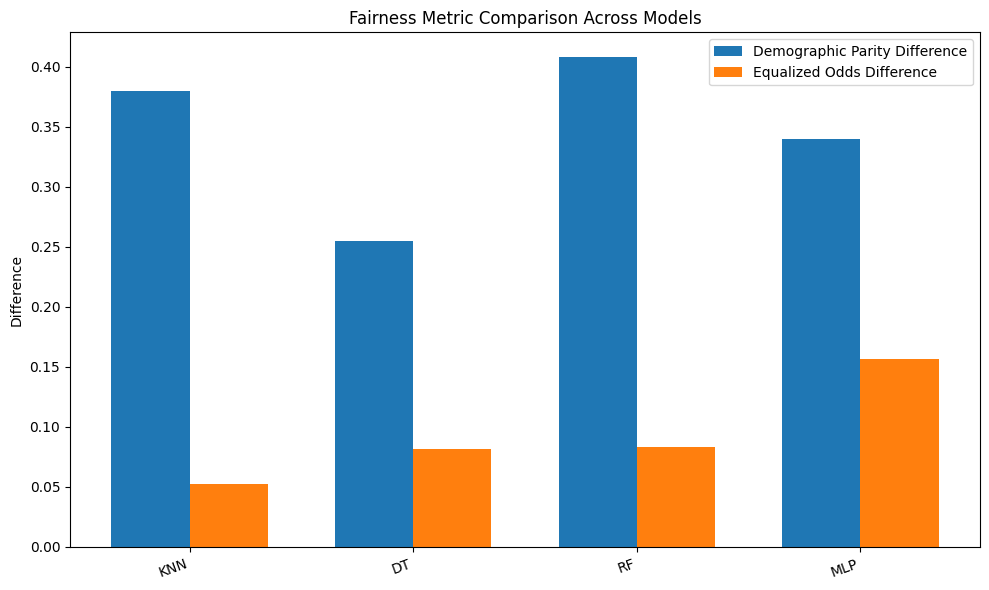

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

## Fairness Metric Comparison Across Models  

The bar chart compares two fairness metrics across the four models (**KNN, Decision Tree, Random Forest, MLP**):  
- **Demographic Parity Difference (DPD)** – measures disparity in positive outcome distribution between genders.  
- **Equalized Odds Difference (EOD)** – measures disparity in error rates (TPR and FPR) across genders.  

---

### 1. Demographic Parity Difference (DPD)  
- **Highest DPD:** Random Forest (≈0.41) → shows the **largest disparity** in outcome distribution, with males receiving more positive predictions than females.  
- **Lowest DPD:** Decision Tree (≈0.25) → still notable, but relatively smaller compared to other models.  
- **KNN and MLP:** Both around 0.34–0.38, indicating persistent disparities in outcome distribution.  
- **Interpretation:** All models exhibit **outcome bias**, reflecting the **imbalanced training set (75% male, 25% female)**.  

---

### 2. Equalized Odds Difference (EOD)  
- **Lowest EOD:** KNN (≈0.05) → achieves the most balanced error rates between genders.  
- **Highest EOD:** MLP (≈0.16) → shows the greatest imbalance in error distribution, meaning males and females are treated differently in misclassification patterns.  
- **DT and RF:** Moderate disparities (≈0.08), suggesting some imbalance but less severe than MLP.  
- **Interpretation:** Models vary more in their **error rate fairness** than in outcome distribution fairness.  

---

### Key Insights:  
- **DPD values are consistently above 0.25 across all models**, showing that **outcome bias is a systemic issue** regardless of algorithm.  
- **EOD differentiates models more clearly:**  
  - **KNN** is the most balanced in error rates.  
  - **MLP** introduces the strongest disparity in misclassification behavior.  
- The fairness trade-off:  
  - **DT** achieves the lowest disparity in outcome distribution (DPD), but still shows moderate error-rate imbalance.  
  - **RF** favors males in outcomes while keeping error rates fairly balanced.  
  - **MLP** reduces outcome disparity compared to RF and KNN but at the cost of the largest error-rate gap.  

---

### Summary:  
- **Demographic Parity (DPD) remains a concern across all models**, with females consistently receiving fewer positive outcomes, driven by the **75/25 male–female imbalance in training data**.  
- **KNN is fairest in error-rate balance (EOD)**, while **DT is fairest in outcome distribution (lowest DPD)**.  
- From a fairness perspective, no model achieves parity, but the choice of metric (DPD vs. EOD) changes which model appears more equitable.  

---

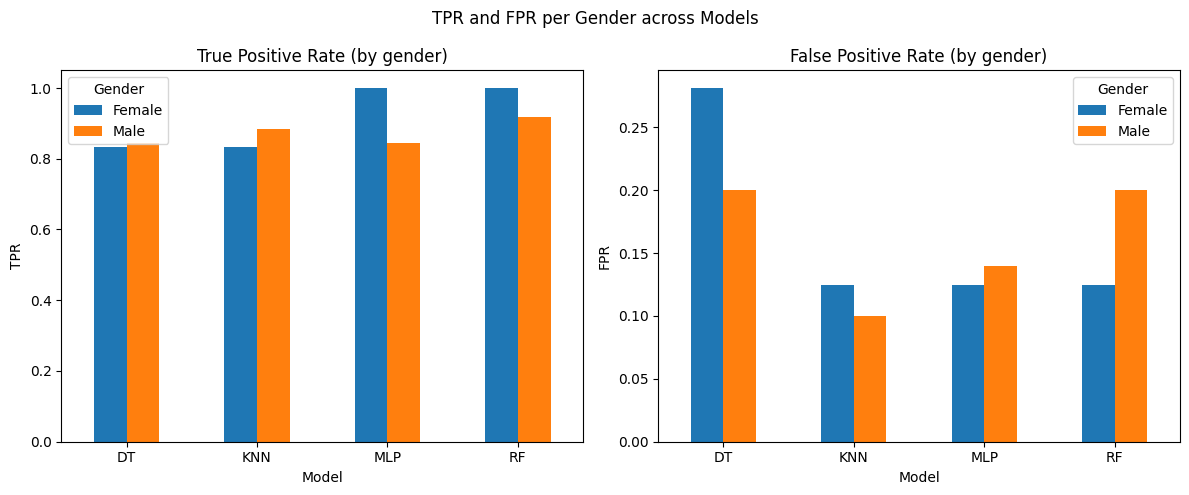

In [29]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

## Comparison of True Positive Rate (TPR) and False Positive Rate (FPR) by Gender Across Models  

The figure compares **True Positive Rate (TPR)** and **False Positive Rate (FPR)** between **females (blue)** and **males (orange)** across four models: Decision Tree (DT), KNN, MLP, and Random Forest (RF).  

---

### 1. True Positive Rate (TPR)  
- **DT:** TPR is very similar between females (~0.83) and males (~0.84), indicating balanced sensitivity.  
- **KNN:** Males (~0.89) slightly outperform females (~0.83), suggesting the model detects more true positives for males.  
- **MLP:** Females achieve perfect sensitivity (1.00), while males are lower (~0.84), showing the model never misses positive female cases but underperforms for males.  
- **RF:** Females again achieve perfect sensitivity (1.00), while males (~0.92) are slightly disadvantaged.  

**Interpretation:**  
- **DT and KNN** lean slightly toward males in TPR.  
- **MLP and RF** strongly favor females in TPR, with perfect detection of female cases.  

---

### 2. False Positive Rate (FPR)  
- **DT:** Females (~0.28) have a higher FPR than males (~0.20), meaning females are more often incorrectly classified as positive.  
- **KNN:** Females (~0.13) have slightly higher FPR than males (~0.10), but the difference is small.  
- **MLP:** Males (~0.14) have a slightly higher FPR than females (~0.13).  
- **RF:** Males (~0.20) show a higher FPR compared to females (~0.13).  

**Interpretation:**  
- **DT** disadvantages females in terms of false alarms.  
- **RF** disadvantages males.  
- **KNN** is the most balanced in FPR.  
- **MLP** shows only a minor imbalance.  

---

### Key Insights: 
- **Gender Advantage in TPR:**  
  - **Males benefit in KNN** (higher TPR).  
  - **Females benefit in MLP and RF** (perfect TPR).  
  - **DT is balanced.**  

- **Gender Disadvantage in FPR:**  
  - **Females suffer more false positives in DT.**  
  - **Males suffer more false positives in RF.**  
  - **KNN and MLP** are relatively balanced.  

---

### Summary:  
- **KNN** emerges as the most balanced model overall, with only small gender gaps in both TPR and FPR.  
- **DT** is balanced in sensitivity but disadvantages females through higher false positives.  
- **RF** favors females in sensitivity but disadvantages males with more false positives.  
- **MLP** heavily favors females in sensitivity (TPR = 1.0) while keeping false positives fairly balanced.  

➡️ **Conclusion:** The figure illustrates that **fairness outcomes differ by model**. While KNN is the most equitable in error distribution, DT and RF show clear gender trade-offs, and MLP strongly advantages females in recall at the expense of higher male misclassifications.

---

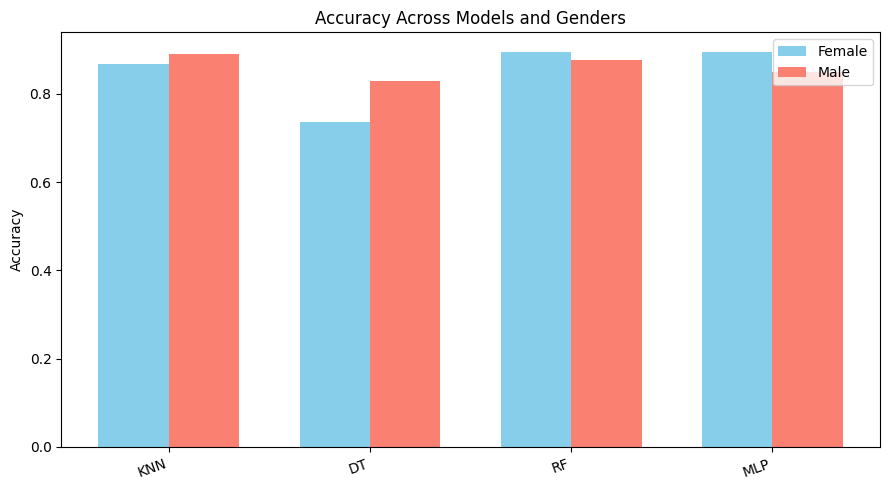

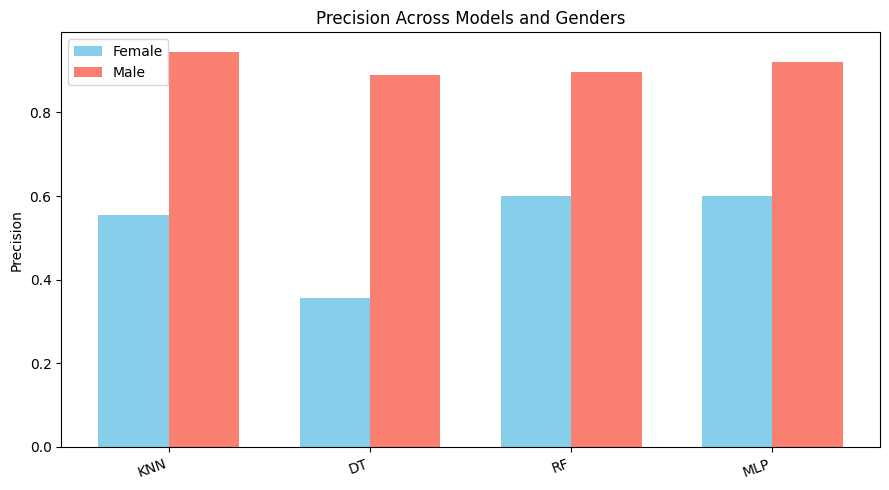

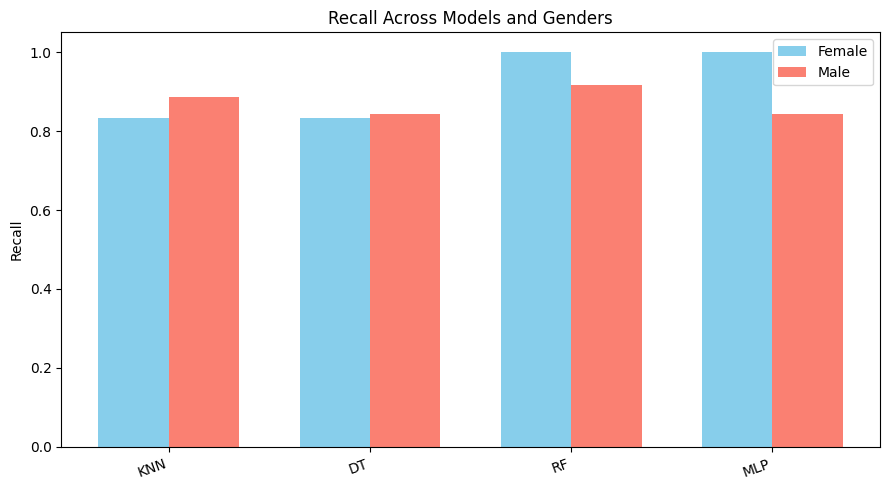

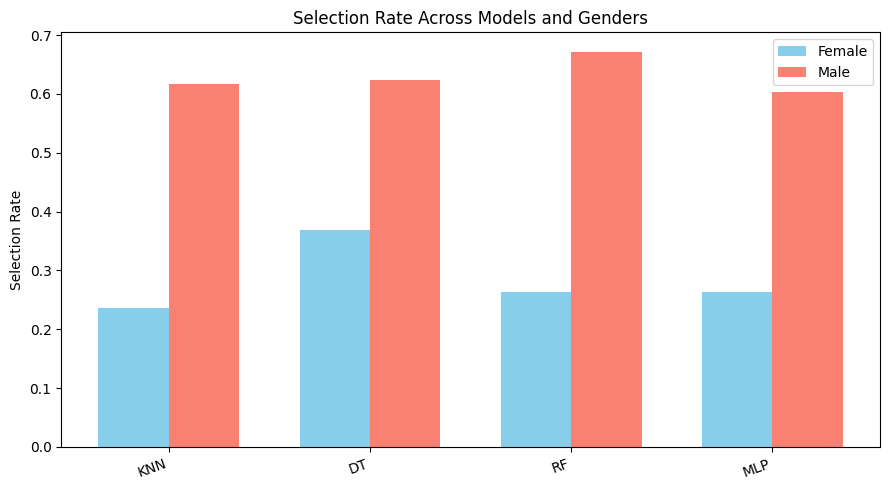

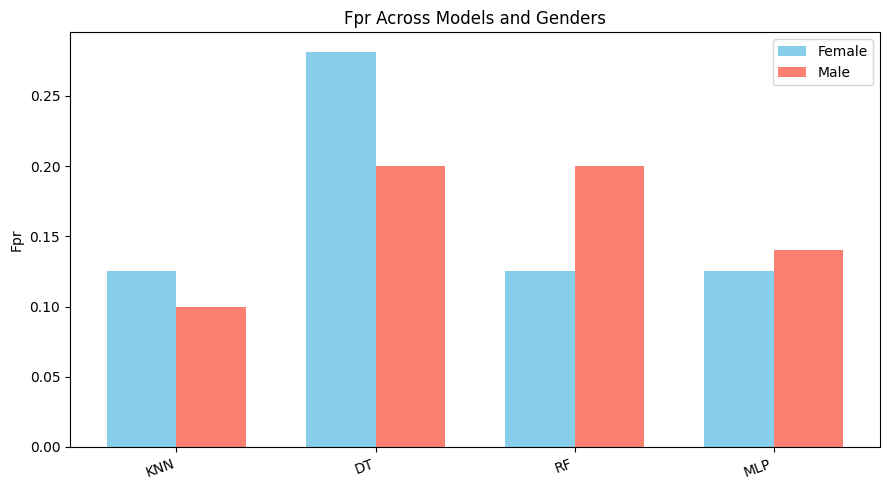

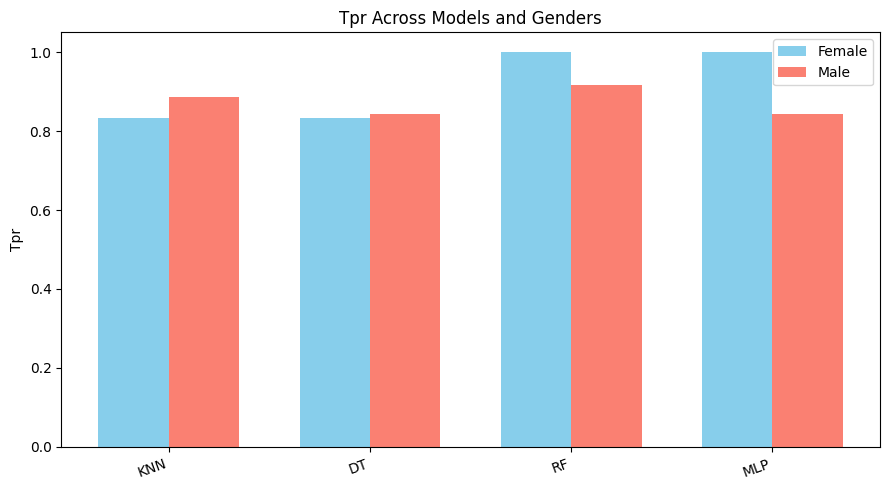

In [31]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Fairness Metrics Across Models and Genders  

The figures summarize **accuracy, precision, recall, selection rate, false positive rate (FPR), and true positive rate (TPR)** across the four models (**KNN, Decision Tree, Random Forest, MLP**) for both genders.  

---

### 1. Accuracy  
- **KNN, RF, and MLP:** Accuracy is similar across genders, with only minor differences.  
- **DT:** Lower accuracy for females (~0.74) compared to males (~0.83).  
- **Interpretation:** Most models achieve balanced accuracy, though DT is less consistent, performing worse for females.  

---

### 2. Precision  
- Across **all models**, males have **much higher precision** (0.87–0.95) compared to females (~0.36–0.60).  
- **Interpretation:** Positive predictions are **far more reliable for males**, showing systemic bias in prediction quality.  

---

### 3. Recall  
- **Females have higher recall in RF and MLP (1.0)**, meaning these models never miss positive female cases.  
- **Males have slightly higher recall in KNN**, while **DT is nearly balanced**.  
- **Interpretation:** A trade-off exists: females benefit from higher sensitivity (RF, MLP), while males benefit in KNN.  

---

### 4. Selection Rate  
- **Males consistently have much higher selection rates (0.60–0.67) than females (~0.24–0.37)** across all models.  
- **Interpretation:** Males are systematically more likely to receive positive predictions, reflecting outcome bias that aligns with the male-heavy training data (75% male vs. 25% female).  

---

### 5. False Positive Rate (FPR)  
- **DT:** Females (~0.28) have a much higher FPR than males (~0.20), meaning more false alarms for women.  
- **RF:** Males (~0.20) have a higher FPR than females (~0.13).  
- **KNN and MLP:** Both show small gender gaps, with females slightly worse in KNN and males slightly worse in MLP.  
- **Interpretation:** DT disadvantages females through false alarms, while RF disadvantages males.  

---

### 6. True Positive Rate (TPR)  
- **RF and MLP:** Females achieve perfect TPR (1.0), outperforming males.  
- **KNN:** Males have higher TPR (~0.89 vs. 0.83).  
- **DT:** Balanced between genders (~0.83 each).  
- **Interpretation:** RF and MLP strongly favor females in sensitivity, while KNN favors males.  

---

### Key Insights:  
- **Males are systematically advantaged in precision, F1, and selection rate** across all models, meaning they are more likely to receive positive predictions and benefit from more reliable classifications.  
- **Females are advantaged in recall/TPR in RF and MLP**, achieving perfect sensitivity (no missed positives), though at the cost of much lower selection rates.  
- **DT is the least balanced model**, performing worse for females in both accuracy and false positives.  
- **KNN is the most balanced overall**, though it still favors males in outcome access and precision.  

---

### Conclusion  
The analysis shows a **fairness trade-off across models**:  
- **Males (majority group)** are consistently advantaged in outcome distribution (higher selection rates, precision, and overall access to positive predictions).  
- **Females (minority group)** benefit from stronger sensitivity and probability quality (higher recall/TPR in RF and MLP, better ROC-AUC and Brier scores).  

This duality reflects the **75/25 male–female imbalance in training data**, which biased the models toward **male outcome access**, while simultaneously allowing **females to achieve stronger probability discrimination and calibration**.  

---